<a href="https://colab.research.google.com/github/mukul-rathi/workshop-deep-learning/blob/master/FeedforwardNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feedforward Neural Networks

This Jupyter notebook accompanies the blog post on Feedforward Neural Networks

First, we will import the dependencies - **numpy**, the python linear algebra library, **pandas** to load and preprocess the input data and **matplotlib** for visualisation purposes.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston,load_breast_cancer


 First, the house dataset - this is the dataset we used for linear regression.

In [0]:
X,y = load_boston(return_X_y=True)
#X,y = load_breast_cancer(return_X_y=True)

# make sure dimensions are right
X = X.T
y = np.reshape(y, (1,y.shape[0]))


#normalise the data
mean = np.mean(X, axis=1, keepdims=True)
std = np.std(X, axis=1,keepdims = True)
X -=mean
X /= std


X_train = X[:,:2*X.shape[0]//3]
Y_train = y[:,:2*X.shape[0]//3]

X_test = X[:,2*X.shape[0]//3:]
Y_test = y[:,2*X.shape[0]//3:]


# Creating the neural network:

Having preprocessed our data into matrices, it is now time to create the feedforward neural network. 

First we need to initialise parameters: the weights and biases for each layer.

The weights for layer *$l$* are stored in *$ W^{(l)}$*, a *$n_l$ x $n_{(l-1)}$* matrix, where *$n_l$* is the number of units in layer *$l$*. 
We  initialise the weights randomly from a Gaussian distribution ($\mu=0, \sigma =1$) to break symmetry, and multiply by 0.001 to ensure weights aren't too large.

The biases for layer *$l$* are stored in *$ b^{(l)}$*, which is a *$n_l$ x 1* matrix.

In [0]:
def initialise_parameters(layers_units):
    parameters = {}            # create a dictionary containing the parameters
    for l in range(1, len(layers_units)):
        parameters['W' + str(l)] = 0.001* np.random.randn(layers_units[l],layers_units[l-1])
        parameters['b' + str(l)] = np.zeros((layers_units[l],1))
    return parameters

The activation function $g(z)$ we will be using is the ReLU function $g(z) = max(0,z)$ in the hidden layers.

<br> The only difference in the neural net between regression and classification is the final layer - whether we use the sigmoid function in the final layer, depending on whether we want to do regression or classification. 

NB: Although the ReLU function is technically non-differentiable when $z=0$, in practice we can set the derivative=0 at $z=0$.

In [0]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(z, deriv = False):
    if(deriv):
        return z>0
    else:
        return np.multiply(z, z>0)

We can now write the code for the forward propagation step.

In each layer $l$ , we matrix multiply the output of the previous layer $A^{(l-1)}$  by a weight matrix $W^{(l)}$ and then add a bias term $b^{(l)}$. We then take the result $Z^{(l)}$ and apply the activation function $g(z)$ to it to get the output $A^{(l)}$. $L$ = number of layers.
The equations are thus:
$$Z^{(l)}=W^{(l)}A^{(l-1)}$$
$$A^{(l)}=g(Z^{(l)})$$


In [0]:
def forward_propagation(X,parameters):
    cache = {}
    L = len(parameters)//2 #final layer
    cache["A0"] = X #ease of notation since input = layer 0
    for l in range(1, L):
        cache['Z' + str(l)] = np.dot(parameters['W' + str(l)],cache['A' + str(l-1)]) + parameters['b' + str(l)]
        cache['A' + str(l)] = relu(cache['Z' + str(l)])
    #final layer
    cache['Z' + str(L)] = np.dot(parameters['W' + str(L)],cache['A' + str(L-1)]) + parameters['b' + str(L)]
    cache['A' + str(L)] =cache['Z' + str(L)] 
    return cache 

Next we can compute the loss function - this is the objective function the neural network will aim to minimise during training:

$m$ = number of training examples, $(x^{(i)},y^{(i)})$ is the $i^{th}$ training example.
<br> For regression: 
$$ J(W^{(1)}, b^{(1)},...) = \frac{1}{2m} \sum_{i=1}^{m} (a^{(L) (i)} - y^{(i)})^2 $$


For classification: 

$$J(W^{(1)}, b^{(1)},...) = -\frac{1}{m} \sum\limits_{i = 1}^{m} y^{(i)}\log\left(a^{(L) (i)}\right) + (1-y^{(i)})\log\left(1- a^{(L)(i)}\right) $$



In [0]:
def cost_function(AL,Y):
    m = Y.shape[1]
    cost = (1/(2*m))*(np.sum(np.square(AL-Y)))
    return cost

Now we will code the backpropagation algorithm. This will enable us to calculate the partial derivative of the cost function with respect to each of the weights and biases in each of the layers of the network. The equations can be derived using the multivariable chain rule and are the same for both regression and classification:
$$\frac{\partial \mathcal{J} }{\partial Z^{(L)}} = A^{(L)} - Y$$ 


$$ \frac{\partial \mathcal{J} }{\partial W^{(l)}} = \frac{1}{m}\frac{\partial \mathcal{J} }{\partial Z^{(l)}} A^{(l-1) T} $$

$$ \frac{\partial \mathcal{J} }{\partial b^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m} \frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}}$$

$$ \frac{\partial \mathcal{J} }{\partial A^{(l-1)}} = W^{(l) T} \frac{\partial \mathcal{J} }{\partial Z^{(l)}} $$
$$ \frac{\partial \mathcal{J} }{\partial Z^{(l-1)}} = \frac{\partial \mathcal{J} }{\partial A^{(l-1)}}*g^{'}(Z^{(l-1)})$$




In [0]:
def backpropagation(cache,Y,parameters):
    L = len(parameters)//2 
    m = Y.shape[1]
    grads = {}
    grads["dZ" + str(L)]= cache["A" + str(L)] - Y
    grads["dW" + str(L)]= (1/m)*np.dot(grads["dZ" + str(L)],cache["A" + str(L-1)].T) 
    grads["db" + str(L)]= (1/m)*np.sum(grads["dZ" + str(L)],axis=1,keepdims=True)
    for l in range(L-1,0,-1):
        grads["dA" + str(l)]= np.dot(parameters["W" + str(l+1)].T,grads["dZ" + str(l+1)])
        grads["dZ" + str(l)]= np.multiply(grads["dA" + str(l)], relu(cache["Z" + str(l)], deriv = True))
        grads["dW" + str(l)]= (1/m)*np.dot(grads["dZ" + str(l)],cache["A" + str(l-1)].T) 
        grads["db" + str(l)]= (1/m)*np.sum(grads["dZ" + str(l)],axis=1,keepdims=True)
    return grads

We need to have an evaluation metric to see if the model is actually learning.

For regression, we use Mean Squared Error.

Now let's combine the functions created so far to create a model and train it using  gradient descent. 

The update equations for the parameters are as follows:
$$ W^{(l)} = W^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial W^{(l)}} $$

$$ b^{(l)} = b^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial b^{(l)}} $$

where $\alpha$ is the learning rate parameter.

In [0]:
def train_model(X_train, Y_train,num_epochs,layers_units,learning_rate):
    train_costs = []
    
    parameters = initialise_parameters(layers_units)
    L = len(layers_units)-1 
    for epoch in range (num_epochs):
        #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
        #and biases. Calculate the cost - used to monitor training
        cache = forward_propagation(X_train,parameters)
        cost = cost_function(cache["A" + str(L)],Y_train)
        grads = backpropagation(cache,Y_train,parameters)

        #update the parameters using gradient descent
        for l in range(1,L+1):
            parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*grads["dW" + str(l)]
            parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*grads["db" + str(l)]

        #periodically output an update on the current cost and performance on the dev set for visualisation
        train_costs.append(cost)
        if(epoch%(num_epochs//10)==0):
            print("Training the model, epoch: " + str(epoch+1))
            print("Cost after epoch " + str((epoch)) + ": " + str(cost))
    print("Training complete!")
    #return the trained parameters and the visualisation metrics
    return parameters, train_costs

To evaluate the model, we visualise the training set error over the number of iterations. We then output the final value of the evaluation metric for training and test sets.

In [0]:
def evaluate_model(train_costs,parameters,X_train, Y_train, X_test, Y_test):
    #plot the graphs of training set error
    plt.plot(np.squeeze(train_costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.title("Training Set Error")
    plt.show()
    L = len(parameters)//2
    
    #For train and test sets, perform a step of forward propagation to obtain the trained model's 
    #predictions and evaluate this
    
    train_cache = forward_propagation(X_train,parameters)
    train_AL = train_cache["A"+ str(L)]
    
    print("The train set MSE is: "+str(cost_function(train_AL,Y_train)))
        
    test_cache = forward_propagation(X_test,parameters)
    test_AL = test_cache["A"+ str(L)]
    
    print("The test set MSE is: "+str(cost_function(test_AL,Y_test)))
    

We now can write the overall function to run the neural network - this ensures it is easy to run subsequent models by packaging all the functions into one line of code.

In [0]:
#define the hyperparameters for the model
num_epochs = 1500 #number of passes through the training set
layers_units = [X.shape[0], 1] #layer 0 is the input layer
learning_rate = 1e-4


In [11]:
parameters, train_costs = train_model(X_train, Y_train ,num_epochs,layers_units,learning_rate)         

Training the model, epoch: 1
Cost after epoch 0: 422.1860647701419
Training the model, epoch: 151
Cost after epoch 150: 407.5661762677985
Training the model, epoch: 301
Cost after epoch 300: 393.5607498789798
Training the model, epoch: 451
Cost after epoch 450: 380.1447504504729
Training the model, epoch: 601
Cost after epoch 600: 367.2941658166171
Training the model, epoch: 751
Cost after epoch 750: 354.9859639673048
Training the model, epoch: 901
Cost after epoch 900: 343.19805206407676
Training the model, epoch: 1051
Cost after epoch 1050: 331.90923722230025
Training the model, epoch: 1201
Cost after epoch 1200: 321.0991889811378
Training the model, epoch: 1351
Cost after epoch 1350: 310.74840338657725
Training complete!


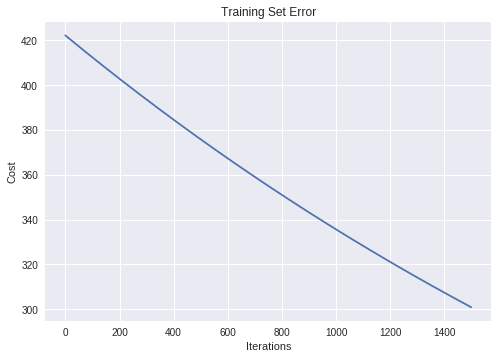

The train set MSE is: 300.8381686161749
The test set MSE is: 308.0581336552814


In [12]:
evaluate_model(train_costs,parameters,X_train, Y_train, X_test, Y_test)